In [ ]:
import pandas as pd
import geopandas as gpd
import numpy as np
from tqdm import tqdm

In [27]:
from pyproj import Geod, CRS
from shapely.geometry import Point, LineString

In [ ]:
import osmnx as ox
import networkx as nx
import gc
ox.config(use_cache=True, log_console=True)

In [30]:
from itertools import product

In [53]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns
sns.reset_defaults()

plt.style.use("dark_background")

In [75]:
import geojson
import os
import json
from shapely.geometry import mapping
from shapely.geometry.multilinestring import MultiLineString

In [28]:
GEOD = CRS.from_epsg(4326).get_geod()

## Load WB data

In [2]:
df = pd.read_csv('./simple_cases.csv')

## Load OSM places data

In [7]:
import unicodedata as ud

# https://stackoverflow.com/a/15547803/5908685
def rmdiacritics(char):
    '''
    Return the base character of char, by "removing" any
    diacritics like accents or curls and strokes and the like.
    '''
    desc = ud.name(char)
    cutoff = desc.find(' WITH ')
    if cutoff != -1:
        desc = desc[:cutoff]
        try:
            char = ud.lookup(desc)
        except KeyError:
            pass  # removing "WITH ..." produced an invalid name
    return char

def remove_diacritics(s: str):
    return ''.join(map(rmdiacritics, s))


In [24]:
gdf = gpd.read_file('guatemala-latest-free.shp/gis_osm_places_free_1.shp')
print('initial', len(gdf))
gdf = pd.DataFrame(gdf[~gdf.name.isnull()])
print('non-null name', len(gdf))
gdf = pd.DataFrame(gdf[~gdf.name.str.contains('^km\.?\s+\d+$', case=False)])
print('no KM markers', len(gdf))
gdf = pd.DataFrame(gdf[~gdf.name.str.contains('^zona\.?\s+\d+$', case=False)])
print('no zone markers', len(gdf))
gdf.loc[:, 'name'] = gdf.name.str.lower().map(remove_diacritics)

initial 2371
non-null name 2210
no KM markers 1550
no zone markers 1508


In [ ]:
places = np.array(gdf.name.to_list())
places_set = set(places)
places_to_geoms = {}
for p in places_set:
    g = gdf[places == p].geometry.to_list()
    places_to_geoms[p] = g
places_to_geoms

In [ ]:
highway_types_to_inlcude = '|'.join([
    'primary',
    'secondary',
    'tertiary',
    'trunk',
    'motorway',
    'unclassified',
    'primary_link',
    'secondary_link',
    'tertiary_link',
    'trunk_link',
    'motorway_link'
])
custom_filter = f'["highway"~"{highway_types_to_inlcude}"]'

G = ox.graph_from_place(
    'Guatemala',
    network_type='drive',
    custom_filter=custom_filter,
    simplify=False)

gc.collect()

Save graph:

In [ ]:
# ox.save_graphml(G, 'graph.graphml')

Load saved graph:

In [ ]:
# G = ox.load_graphml('graph.graphml')
gc.collect()

In [42]:
def straight_line_distance(p1, p2):
    line_string = LineString((p1, p2))
    dist = GEOD.geometry_length(line_string)
    return dist

def get_route_info(G, p1, p2, km=True):
    start = p1.coords[0]
    end = p2.coords[0]
    start_node = ox.distance.nearest_nodes(G, *start)
    end_node = ox.distance.nearest_nodes(G, *end)

    route = None
    route_length = np.inf
    try:
        route = nx.shortest_path(G, start_node, end_node, weight='length')
        route_length = nx.shortest_path_length(
            G, start_node, end_node, weight='length')
    except:
        pass
    out = {
        'start_node': start_node,
        'end_node': end_node,
        'route': route,
        'length': route_length / 1e3 if km else route_length,
    }
    return out

def select_points(p1_candidates, p2_candidates, wb_length):
    pairs = list(product(p1_candidates, p2_candidates))
    straight_dists = [straight_line_distance(p1, p2) for p1, p2 in pairs]
    straight_dists = np.array(straight_dists) / 1e3
    diffs = np.abs(straight_dists - wb_length)
    min_diff_idx = np.argmin(diffs)
    p1, p2 = pairs[min_diff_idx]
    min_diff_dist = straight_dists[min_diff_idx]
    return p1, p2, min_diff_dist

In [51]:
matches = []
with tqdm(df.itertuples(), total=len(df)) as bar:
    for i, row in enumerate(bar):
        p1_name = row.endpoint_1
        p2_name = row.endpoint_2
        p1_candidates = places_to_geoms.get(p1_name, None)
        p2_candidates = places_to_geoms.get(p2_name, None)
        if p1_candidates is None or p2_candidates is None:
            continue
            
        wb_length = float(row.length)
        
        p1, p2, straight_line_dist = select_points(p1_candidates, p2_candidates, wb_length)

        if abs(wb_length - straight_line_dist) > 20:
            print(f'Skipping {p1_name} -- {p2_name}: wb_length={wb_length:.1f}, st_ln_dist={straight_line_dist:.1f}')
            continue

        route_info = get_route_info(G, p1, p2)
        info = {
            'p1_name': p1_name,
            'p2_name': p2_name,
            'p1': p1,
            'p2': p2,
            'wb_length': wb_length,
            'straight_line_dist': straight_line_distance(p1, p2) / 1e3
        }
        info.update(route_info)
        info['diff'] = wb_length - route_info['length']
        info['rel_error'] = abs(info['diff']) / wb_length

        bar.set_postfix({
            'start': p1_name,
            'end': p2_name,
            'diff': info['diff'],
            'matches': len(matches)
        })
        matches.append(info)
gc.collect()

  3%|▎         | 11/318 [00:18<17:53,  3.50s/it, start=acatenango, end=la soledad, diff=-1.46, matches=2] 

Skipping san benito -- el recreo: wb_length=9.4, st_ln_dist=126.7
Skipping san benito -- santa rita: wb_length=17.6, st_ln_dist=69.0
Skipping santa rita -- la libertad: wb_length=7.9, st_ln_dist=61.9


 23%|██▎       | 74/318 [02:06<11:55,  2.93s/it, start=salama, end=llano grande, diff=0.889, matches=19]                     

Skipping chiquimula -- la laguna: wb_length=9.5, st_ln_dist=104.1
Skipping san jacinto -- san martin jilotepeque: wb_length=8.9, st_ln_dist=139.4


 37%|███▋      | 117/318 [03:26<16:43,  4.99s/it, start=san antonio suchitepequez, end=santo tomas la union, diff=0.36, matches=32]

Skipping palin -- nuevo progreso: wb_length=4.3, st_ln_dist=138.6


 43%|████▎     | 138/318 [03:51<11:23,  3.80s/it, start=san francisco el alto, end=momostenango, diff=-.0981, matches=36]          

Skipping san francisco -- el progreso: wb_length=4.3, st_ln_dist=119.3


 46%|████▌     | 147/318 [04:10<10:31,  3.69s/it, start=chicacao, end=san miguel panan, diff=-.0221, matches=39]         

Skipping salama -- tempisque: wb_length=10.0, st_ln_dist=100.0
Skipping san jeronimo -- santa barbara: wb_length=7.4, st_ln_dist=102.7


 49%|████▉     | 156/318 [04:16<07:31,  2.79s/it, start=santa lucia utatlan, end=san jose chacaya, diff=-6.71, matches=40]

Skipping el silencio -- las cruces: wb_length=2.4, st_ln_dist=293.5


 52%|█████▏    | 166/318 [04:29<05:33,  2.19s/it, start=palencia, end=los mixcos, diff=-1.89, matches=42]                 

Skipping los mixcos -- santa rita: wb_length=5.7, st_ln_dist=45.7
Skipping santa rita -- san jose pinula: wb_length=8.7, st_ln_dist=54.7
Skipping el carrizal -- chuarrancho: wb_length=7.5, st_ln_dist=96.9


 54%|█████▍    | 172/318 [04:35<04:28,  1.84s/it, start=san juan sacatepequez, end=sajcavilla, diff=1.82, matches=43]

Skipping teculutan -- la palmilla: wb_length=4.2, st_ln_dist=65.0


 59%|█████▉    | 189/318 [04:54<08:24,  3.91s/it, start=cabanas, end=san diego, diff=-.433, matches=46]              

Skipping san raymundo -- el carrizal: wb_length=6.5, st_ln_dist=86.4


 61%|██████▏   | 195/318 [05:07<06:28,  3.16s/it, start=huitan, end=cabrican, diff=-.176, matches=48]         

Skipping san sebastian -- el obraje: wb_length=5.1, st_ln_dist=229.0
Skipping el cedro -- chiriqui: wb_length=6.0, st_ln_dist=208.8


 65%|██████▍   | 206/318 [05:13<04:26,  2.38s/it, start=agua chiquita, end=tuila, diff=0.297, matches=49]

Skipping santa isabel -- actela: wb_length=7.8, st_ln_dist=269.0


 68%|██████▊   | 217/318 [05:44<05:22,  3.19s/it, start=guastatoya, end=el rancho, diff=1.08, matches=54]             

Skipping nenton -- finca la trinidad: wb_length=29.9, st_ln_dist=184.1


 79%|███████▉  | 252/318 [06:34<03:33,  3.24s/it, start=chiquimula, end=san jose la arada, diff=0.679, matches=62]             

Skipping ipala -- agua tibia: wb_length=6.1, st_ln_dist=66.7


 81%|████████  | 256/318 [06:46<04:01,  3.89s/it, start=flores costa cuca, end=coatepeque, diff=-2.97, matches=64]

Skipping el pinal -- comapa: wb_length=10.1, st_ln_dist=50.4


 83%|████████▎ | 263/318 [07:11<04:22,  4.78s/it, start=santa cruz del quiche, end=san antonio ilotenango, diff=-1.62, matches=68]

Skipping jutiapa -- las anonas: wb_length=16.2, st_ln_dist=51.2
Skipping las anonas -- ayarza: wb_length=9.1, st_ln_dist=64.9


 86%|████████▌ | 273/318 [07:24<03:18,  4.41s/it, start=san andres sajcabaja, end=canilla, diff=-.828, matches=70]                

Skipping jalapa -- el tablon: wb_length=5.3, st_ln_dist=38.9


 88%|████████▊ | 279/318 [07:30<02:12,  3.40s/it, start=el progreso, end=horcones, diff=-23.3, matches=71]        

Skipping pinalito -- san pedro pinula: wb_length=3.8, st_ln_dist=62.3
Skipping el tablon -- pinalito: wb_length=10.6, st_ln_dist=73.7


 94%|█████████▎| 298/318 [08:01<01:18,  3.91s/it, start=cuilco, end=tectitan, diff=-1.39, matches=76]                             

Skipping chajul -- ilom: wb_length=46.0, st_ln_dist=20.6


 96%|█████████▌| 306/318 [08:26<00:46,  3.87s/it, start=san pedro pinula, end=san luis jilotepeque, diff=0.24, matches=80]

Skipping palencia -- agua caliente: wb_length=16.9, st_ln_dist=96.8


100%|██████████| 318/318 [08:33<00:00,  1.61s/it, start=san marcos, end=san rafael pie de la cuesta, diff=0.0967, matches=81]


In [54]:
diffs = np.array([m['diff'] for m in matches if abs(m['diff']) < np.inf])

In [56]:
nmatched = (np.abs(diffs) < 5).sum()
nmatched, nmatched / len(df)

(75, 0.2358490566037736)

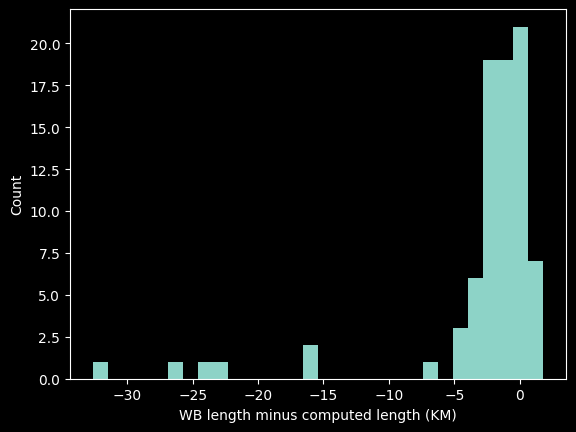

In [63]:
plt.hist(diffs, bins=30)
plt.xlabel('WB length minus computed length (KM)')
plt.ylabel('Count')
plt.show()

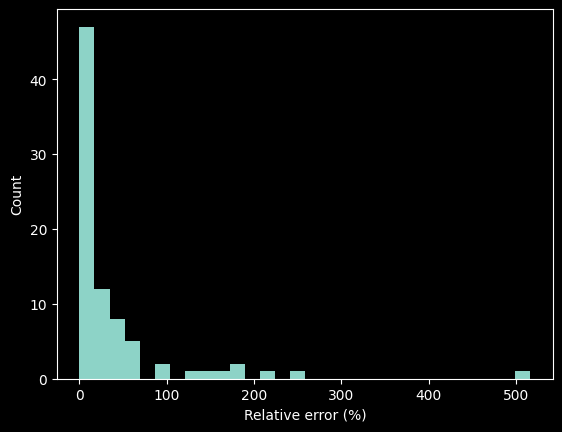

In [64]:
plt.hist([m['rel_error']*100 for m in matches], bins=30)
plt.xlabel('Relative error (%)')
plt.ylabel('Count')
plt.show()

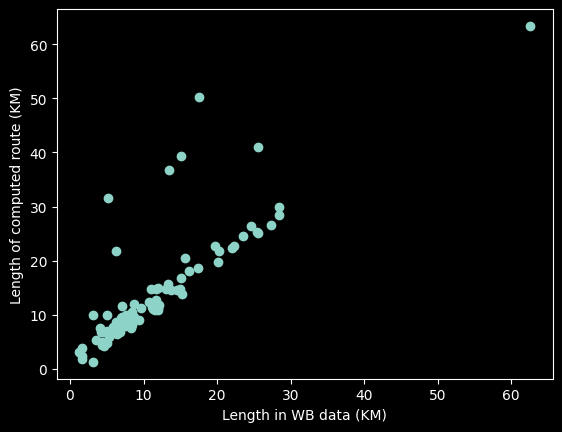

In [59]:
plt.scatter([m['wb_length'] for m in matches], [m['length'] for m in matches])
plt.xlabel('Length in WB data (KM)')
plt.ylabel('Length of computed route (KM)')
plt.show()

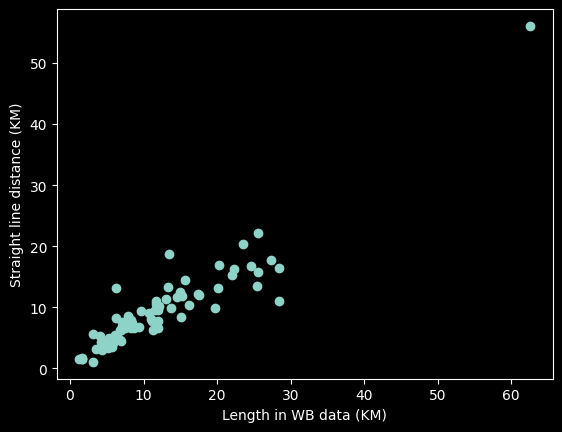

In [65]:
plt.scatter([m['wb_length'] for m in matches], [m['straight_line_dist'] for m in matches])
plt.xlabel('Length in WB data (KM)')
plt.ylabel('Straight line distance (KM)')
plt.show()

## Save matched routes

In [76]:
nodes, edges = ox.graph_to_gdfs(G)

In [77]:
def edges_to_geojson(edge_infos):
    features = []
    for info in edge_infos:
        f = {
            'type': 'Feature',
            'geometry': mapping(info['geometry']),
            'properties': {k: v for (k, v) in info.items() if k not in ['geometry']}
        }
        f['properties']['osmid'] = str(f['properties']['osmid'])
        f['properties']['oneway'] = str(f['properties']['oneway'])
        features.append(f)
    gjson = geojson.FeatureCollection(features)
    return gjson

In [78]:
root = './matched_routes'
os.makedirs(root, exist_ok=True)

with tqdm(matches) as bar:
    for m in bar:
        p1_name = m['p1_name']
        p2_name = m['p2_name']
        route = m['route']
        edge_infos = [
            edges.loc[(u, v, 0)].to_dict()
            for u, v in zip(route[:-1], route[1:])
        ]
        filename = f'{root}/{p1_name}--{p2_name} ({m["diff"]:.1f}, {m["rel_error"]:.1f}).json'
        bar.set_postfix({
            'filename': filename
        })
        gjson = edges_to_geojson(edge_infos)
        with open(filename, 'w') as f:
            json.dump(gjson, f)


100%|██████████| 82/82 [00:08<00:00,  9.13it/s, filename=./matched_routes/san marcos--san rafael pie de la cuesta (0.1, 0.0).json]        
